#Empecemos con algo

In [1]:
import os
import pandas as pd 
%pylab inline
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


En el siguiente código inicializa valores para la ciudad y para la fuente y los paths

In [2]:
base_dir=os.path.join('.','data')
output_dir=os.path.join('.','output')
ciudad='Valledupar'
fuente='IDEAM'

Se crea una funcion que estandariza la carga de datos y permite cargar los datos con una linea

In [3]:
#Funcion que carga la serie de datos segun lo que se esta pidiendo
def cargarserie(base,city,source):
    serie_path=os.path.join(base,city,source+'.csv')
    serie_datos= pd.read_csv(serie_path,sep=';',encoding='latin-1')
    serie_datos= serie_datos.rename(index=str, columns={list(serie_datos)[-1]:'GHI'})
    return serie_datos

Se Carga la serie de Valledupar

In [4]:
serie_pd=cargarserie(base_dir,ciudad,fuente)

# Punto 1

La siguiente función con una serie de datos de GHI cada hora devuelve un dataframe mensual con GHI total al mes y GHI diario mensual

In [5]:
def ghi_por_mes(serie_horaria):
    #Se obtienen las lista de los diferentes años
    agnos=sorted(serie_horaria['AÑO'].unique())
    meses=sorted(serie_horaria['MES'].unique())
    #Se crea un nuevo DATAFRAME donde se tendra la energia por mes
    ghi_df=pd.DataFrame(columns=['AÑO','MES','DIAS','GHImes','GHIdiario'])
     #AÑO
    for agno in agnos:
        for mes in meses:
           #OBTENER la ultima columna (energia)
            n_energia=list(serie_horaria)[-1]
            #Los dias del agno y mes actual (valores unicos)
            dias=serie_horaria[(serie_horaria['AÑO']==agno)&(serie_horaria['MES']==mes)]["DIA"].unique()
            #Energia por metro GHI*1hora [kWh]
            ghi_mes=serie_horaria.loc[(serie_horaria["AÑO"]==agno) & (serie_horaria['MES']==mes),n_energia].sum()/1000
            ghi_dia=ghi_mes/max(dias)
            #Se crea un diccionario de los datos recolectado para obtener el nuevo dataframe
            ghi_dict={"AÑO":agno, "MES":mes, "DIAS":max(dias),
                        "GHImes":ghi_mes,'GHIdiario':ghi_dia}
            #Se anexa el diccionario al final del dataframe que se esta creando
            ghi_df=ghi_df.append(ghi_dict,ignore_index=True)
    return ghi_df



Se hace una prueba inicial para obtener el GHI diario de cada uno y se organizan los datos 

In [6]:
ghi_mensual=ghi_por_mes(serie_pd)
datos_IDEAM=sorted(ghi_mensual["GHIdiario"])

# Punto 2
Graficar la distribucion de energia
A continuacion se grafican los Datos del IDEAM y se presenta la enficc
      

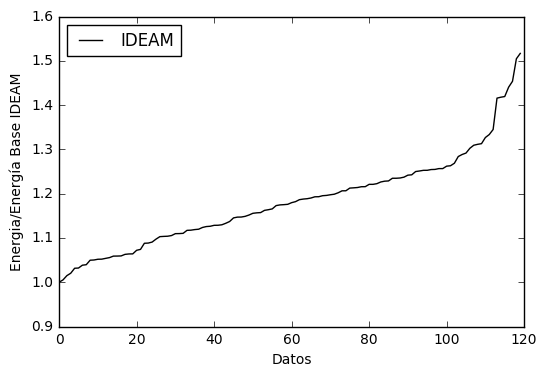

In [7]:
pylab.xlabel("Datos")
pylab.ylabel("Energia/Energía Base IDEAM")
numdatos=range(len(datos_IDEAM))
pylab.plot(numdatos,datos_IDEAM/ datos_IDEAM[0],'-k',label='IDEAM')
pylab.legend(loc='upper left')
pylab.show()
#Para guardar
#pylab.savefig(os.path.join(output_dir,'valledupar_IDEAM.png'), dpi=600)


In [8]:
percentil= 0.01
enficc = ghi_mensual["GHIdiario"].quantile(q=percentil)
print('La ENFICC 99% es:', enficc)

La ENFICC 99% es: 4.56900737661


Función de la ENFICC

In [9]:
def ENFICC(serie):
    ghi_mensual=ghi_por_mes(serie)
    datos=sorted(ghi_mensual["GHIdiario"])
    percentil= 0.01
    valor = ghi_mensual["GHIdiario"].quantile(q=percentil)
    return valor



# Punto 3
Se creara la MCP usando Relacion de Varianzas para ajustar los datos satalitales a aquellos tomados en la tierra

Se inicia con una funcion que permita sacar una serie mas corta segun una fecha de inicio y una duracion 

In [10]:
#Serie Corta
# Parametros son ango, mes inicio y # meses de serie

def serie_corta(serie_larga,ango,mes,duracion):
    #Se calcula el mes en el cual termina la cuenta
    mes_final=(((mes-1)+duracion)%12)+1
    #Se calcula el ango final
    ango_final=ango+(mes+duracion)//12
    #Si es el mismo agno
    if (ango-ango_final==0):
        serie_corta=serie_larga.loc[(serie_larga["AÑO"]>=ango)&(serie_larga["AÑO"]<=ango_final)
                    &(serie_larga["MES"]>=mes)&(serie_larga["MES"]<mes_final)]
    #Si solo es de un ango para el otro
    elif (ango_final-ango==1):
        serie1=serie_larga.loc[(serie_larga["AÑO"]==ango)& (serie_larga["MES"]>=mes)]
        serie2=serie_larga.loc[(serie_larga["AÑO"]==ango_final)& (serie_larga["MES"]<=mes_final)]
        serie_corta=pd.concat([serie1,serie2])
    #Mas de un ango
    else:
        serie1=serie_larga.loc[(serie_larga["AÑO"]==ango)& (serie_larga["MES"]>=mes)]
        serie2=serie_larga.loc[(serie_larga["AÑO"]>ango)&(serie_larga["AÑO"]<ango_final)]
        serie3=serie_larga.loc[(serie_larga["AÑO"]==ango_final)&(serie_larga["MES"]<=mes_final)]
        serie_corta=pd.concat([serie1,serie2,serie3])
    return serie_corta.copy()
  


La siguiente funcion corta un dataframe larga para que tenga las mismas fechas de la corta

In [11]:
#Obtener mismo periodo de 2 series (de la larga sacar las misma que la corta)
def mismo_periodo(serie_corta,serie_larga):
    ango_final=serie_corta["AÑO"].max()
    ango= serie_corta["AÑO"].min()
    mes=serie_corta.loc[serie_corta["AÑO"] == ango]['MES'].min()
    mes_final=serie_corta.loc[serie_corta["AÑO"] == ango_final]['MES'].max()
    
    #Si es el mismo agno
    if (ango==ango_final):
        serie_corta=serie_larga.loc[(serie_larga["AÑO"]==ango)
                    &(serie_larga["MES"]>=mes)&(serie_larga["MES"]<=mes_final)]
    #Si solo es de un ango para el otro
    elif (ango_final-ango==1):
        serie1=serie_larga.loc[(serie_larga["AÑO"]==ango)& (serie_larga["MES"]>=mes)]
        serie2=serie_larga.loc[(serie_larga["AÑO"]==ango_final)& (serie_larga["MES"]<=mes_final)]
        serie_corta=pd.concat([serie1,serie2])
    #Mas de un ango
    else:
        serie1=serie_larga.loc[(serie_larga["AÑO"]==ango)& (serie_larga["MES"]>=mes)]
        serie2=serie_larga.loc[(serie_larga["AÑO"]>ango)&(serie_larga["AÑO"]<ango_final)]
        serie3=serie_larga.loc[(serie_larga["AÑO"]==ango_final)&(serie_larga["MES"]<=mes_final)]
        serie_corta=pd.concat([serie1,serie2,serie3])
    return serie_corta.copy()

A continuacion la funcion de relacion de varianzas con dos series

In [12]:
def prediccion_VR(serie_obC,serie_refL):
    
    serie_refC=mismo_periodo(serie_obC,serie_refL)    
    
    ghi_obCH=serie_obC.iloc[:,-1]
    ghi_refCH=serie_refC.iloc[:,-1]
    ghi_refLH=serie_refL.iloc[:,-1]
    
    mu_obC=ghi_obCH.mean()
    mu_refC=ghi_refCH.mean()
    sigma_obC=ghi_obCH.std()
    sigma_refC=ghi_refCH.std()
    relacionstd=sigma_obC/sigma_refC
    const=mu_obC-(relacionstd)*mu_refC
    #print('%.3f * GHI_ref + %.3f = GHI_ob'% (relacionstd,const))
    ghi_mes_obL=const+relacionstd*ghi_refLH
    # Correccion de noche
    ghi_mes_obL[(serie_refL["HORA"]<=6) | (serie_refL["HORA"]>=19)]= 0 
    
    return ghi_mes_obL
 

Se hace una prueba de las funciones descritas anterior mente y se obtiene una serie ajustadad con el mismo periodo de las mediciones en tierra 

In [13]:
base_dir=os.path.join('.','data')
ciudad='Medellin'
#  ESTO ESTA AL REVES
fObj='IDEAM'
fRef='NREL'

#Cargar cada serie segun la fuente
serie_ob=cargarserie(base_dir,ciudad,fObj)
serie_ref=cargarserie(base_dir,ciudad,fRef)

# de mes 3 2011 por 3 meses
#Solo se puede fechas entre 2006-2015
mes=6
agno=2010
dura=3


serie_obC=serie_corta(serie_ob,agno,mes,dura)
m=prediccion_VR(serie_obC,serie_ref)

ghi_pred=serie_ref.copy()
ghi_pred.loc[:,list(serie_ref)[-1]]=m

ghi_pred=mismo_periodo(serie_ob,ghi_pred).reset_index(drop=True)


# Punto 4
Calculo de errores


Funcion del Valor RMS. Se hace la prueba con una serie inicial. Retorna un porcentaje de error

In [14]:
#Devuelve el error RMS de 2 pandas con el mismo tiempo en porcentaje
def errorRMS(objetivo,modificado):
    mod=np.asarray(list(modificado.iloc[:,-1]))
    ob=np.asarray(list(objetivo.iloc[:,-1]))
    numerador=sqrt((np.square(ob -mod)).mean())
    denominador=ob.max()-ob.min()
    RMS=numerador/denominador
    return RMS*100
print(errorRMS(serie_ob,ghi_pred))

10.1910558873


Funcion error de sesgo. Esta retorna un porcentaje.


In [15]:
#Devuelve el error de sesgo en porcentaje
def error_sesgo(objetivo,modificado):
    mod=np.asarray(list(modificado.iloc[:,-1]))
    ob=np.asarray(list(objetivo.iloc[:,-1]))
    numerador=(mod-ob).sum()
    denominador=ob.sum()
    MBE=numerador/denominador
    return MBE*100
print(error_sesgo(serie_ob,ghi_pred))


4.56604380691


 Funcion KSI : el segundo valor que se imprime debe ser cercano a 0
 

In [16]:
#Retorna el P-Value
def ksi(objetivo,modificado):
    mod=np.asarray(list(modificado.iloc[:,-1]))
    ob=np.asarray(list(objetivo.iloc[:,-1]))
    (a,b)=stats.ks_2samp(ob,mod)
    return b
 
ksi(serie_ob,ghi_pred)

2.7432288032590043e-121

# Punto 5
Analizar efectos de cambiar diferentes parametros

Primero se observara que tan parecido son la linea ajustada con la linea respecto a la objetiva

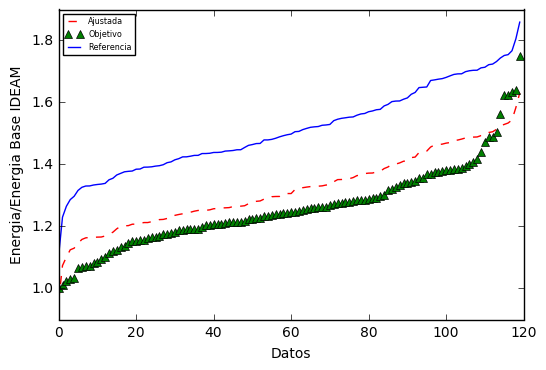

In [55]:
ghi_pred_med=ghi_por_mes(ghi_pred)
datos_pred=sorted(ghi_pred_med["GHIdiario"])

ghi_ob_med=ghi_por_mes(serie_ob)
datos_ob=sorted(ghi_ob_med["GHIdiario"])

ghi_ref_med=mismo_periodo(ghi_ob_med,ghi_por_mes(serie_ref))
datos_ref=sorted(ghi_ref_med["GHIdiario"])

pylab.xlabel("Datos")
pylab.ylabel("Energia/Energia Base IDEAM")
energiab=datos_ob[0]
numdatos=range(len(datos_ob))
num2=range(len(datos_ref))
pylab.plot(numdatos,datos_pred/energiab,'r--',label='Ajustada')
pylab.plot(numdatos,datos_ob/energiab,'g^',label='Objetivo')
pylab.plot(num2,datos_ref/energiab,label='Referencia')
pylab.legend(fontsize='xx-small',loc=2)
pylab.show()

De la anterior grafica se puede declarar que los valores de energia del NREL son mucho mayor a los valores datos por el IDEAM. Nuestro ajuste prueba ser util para asemejar más los valores entre estas dos series. No obstante es importante mencionar que la serie ajustada aun sobreestima la energia que se puede recolectar. En general las tres series muestran tener una distribución similar.Donde al comienzo hay un crecimiento lento pero en los ultimos 10 meses el crecimiento de la energia es alta.  

Ahora buscara observar la diferencia de errores entre las diferentes ciudades y el efecto que tiene el metod de relación de relación de varianzas.

Para permitir un analizis valido se graficaran los 3 tipos de errores con en cada una de las ciudades para los mismos periodos (12 meses)

In [18]:
#Solo se puede fechas entre 2006-2015
mes=1
agno=2011
dura=12

In [19]:
def tres_errores(lugar,year,month,length):
    base_dir=os.path.join('.','data')
    fObj='IDEAM'
    fRef='NREL'
    #Datos cargados directamente
    ghi_ob=cargarserie(base_dir,lugar,fObj)
    ghi_ref=cargarserie(base_dir,lugar,fRef)
    # Se consigue el dato medido corto
    ghi_corto=serie_corta(ghi_ob,year,month,length)
    p=prediccion_VR(ghi_corto,ghi_ref)
    
    #Se termina de crear la serie ajustada
    ghi_aju=ghi_ref.copy()
    ghi_aju.loc[:,list(ghi_ref)[-1]]=p
    
    # La serie ajustadad tiene el mismo tamaño de la objetivo
    ghi_aju=mismo_periodo(ghi_ob,ghi_aju).reset_index(drop=True)
    ghi_ref=mismo_periodo(ghi_ob,ghi_ref).reset_index(drop=True)
    #Errores RMS 
    
    rms_aju=errorRMS(ghi_ob,ghi_aju)
    rms_ref=errorRMS(ghi_ob,ghi_ref)
    #Errores Sesgo
    sesgo_aju=error_sesgo(ghi_ob,ghi_aju)
    sesgo_ref=error_sesgo(ghi_ob,ghi_ref)
    #Ksi
    ksi_aju=ksi(ghi_ob , ghi_aju)
    ksi_ref=ksi(ghi_ob , ghi_ref)

    return {"Ciudad":lugar,"RMS Ajustada":rms_aju,"RMS Referencia":rms_ref,"Sesgo Ajustada":sesgo_aju,"Sesgo Referencia":sesgo_ref,"KSI Ajustada":ksi_aju,"KSI Referencia":ksi_ref}

A continuacion se recorren todas las ciudades y se cargan los datos

In [20]:
ciudades=['Barranquilla','Cali','Carmendebolivar','Medellin',
         'SantaMarta','Sucre','Uribia','Valledupar']
lsterrores=[None]*len(ciudades)

for idx,city in enumerate(ciudades):
    lsterrores[idx]=tres_errores(ciudades[idx],agno,mes,dura)    

errores=pd.DataFrame(lsterrores)


Ahora se aprecia el error RMS de nuestra funcion ajustada

El error promedio RMS Ajustado entre todas las ciudades es de: 9.88%


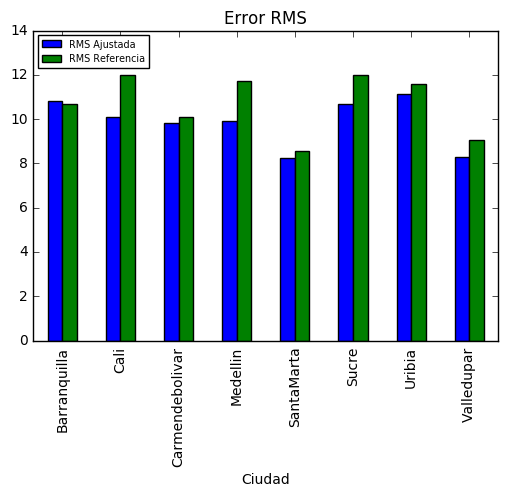

In [21]:
plt_rms=errores.plot(x='Ciudad',y=["RMS Ajustada","RMS Referencia"],kind='bar')
plt_rms.legend(loc=2,fontsize='x-small')
plt_rms.set_title('Error RMS')

meanEr=errores["RMS Ajustada"].mean()
print("El error promedio RMS Ajustado entre todas las ciudades es de: %.2f%%" % meanEr)

Analizando esta grafica es posible ver que en la mayoria de los casos el valor del error RMS disminuye con el uso de el metodo de ajuste. Por otro lado El menor error ocurren en Santa Marta, luego en Carmen de Bolivar y Medellin. El error promedio para este periodo de tiempo es de 9.88%

El Error de Sesgo Promedio absoluto entre las ciudades es de 3.32%


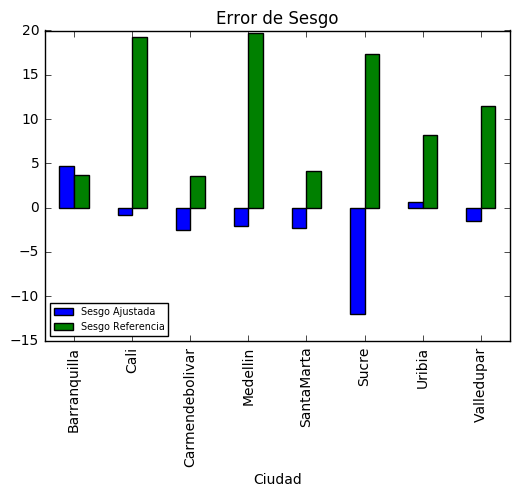

In [22]:
plt_sesgo=errores.plot(x='Ciudad',y=["Sesgo Ajustada","Sesgo Referencia"],kind='bar')
plt_sesgo.legend(loc=3,fontsize='x-small')
plt_sesgo.set_title('Error de Sesgo')

mean_ses=errores["Sesgo Ajustada"].copy().abs().mean()
print("El Error de Sesgo Promedio absoluto entre las ciudades es de %.2f%%"% mean_ses)



De la anterior Grafica es posible observar que el error disminuye en casi todos los casos. Es más en varias ciudades el sesgo paso de ser positivo a ser negativo. Este grafico muestra las ventajas de usar el metodo de relación de varianzas ya que ayuda a disminuir el error de sesgo. Esto confirma lo visto en el primer grafico donde se compraban las distribuciones. 

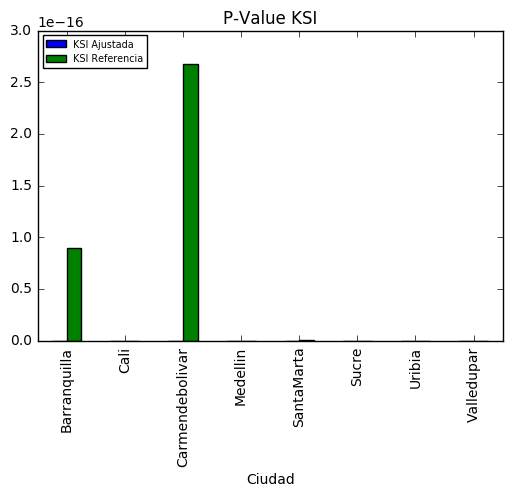

In [23]:
plt_ksi=errores.plot(x='Ciudad',y=["KSI Ajustada","KSI Referencia"],kind='bar')
plt_ksi.legend(loc=2,fontsize='x-small')
plt_ksi.set_title('P-Value KSI')
print( )


La anterior grafica confimar algo que se sospechaba anteriormente. Existe algun error en el calculo de este P-Value

A Continuación se explorara el efecto del periodo de tiempo en el error de sesgo y el erro RMS (ya que el KSI no esta funcionando correctamente). Para explorar esto se hara el procedimiento con:Medellin,SantaMarta y Sucre.

In [24]:
#Solo se puede fechas entre 2008-2015
mes=1
agno=2008

ciudades=["Medellin","SantaMarta","Sucre"]
durac=[1,2,3,6,9,12,15,18,24,36]

erMed=[None]*len(durac)
erSan=[None]*len(durac)
erSuc=[None]*len(durac)
for idx,n in enumerate(durac):
    erMed[idx]=tres_errores(ciudades[0],agno,mes,durac[idx])
    erSan[idx]=tres_errores(ciudades[1],agno,mes,durac[idx])
    erSuc[idx]=tres_errores(ciudades[2],agno,mes,durac[idx])


lst_er_Med=pd.DataFrame(erMed)
lst_er_San=pd.DataFrame(erSan)
lst_er_Suc=pd.DataFrame(erSuc)


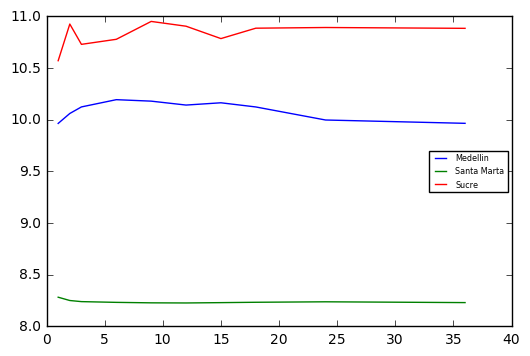

In [25]:
plt.plot(durac,lst_er_Med['RMS Ajustada'],label='Medellin')
plt.plot(durac,lst_er_San['RMS Ajustada'],label='Santa Marta')
plt.plot(durac,lst_er_Suc['RMS Ajustada'],label='Sucre')
plt.legend(fontsize='xx-small',loc=7)
plt.show()

De la anterior grafica se observa que el error RMS realmente no se ve afectado por la duración durante la cual se toma los datos. Lo unico es que a medida que pasa el tiempo se estabilizan los errores. Esto ocurre aproximadamente a 24 meses. 

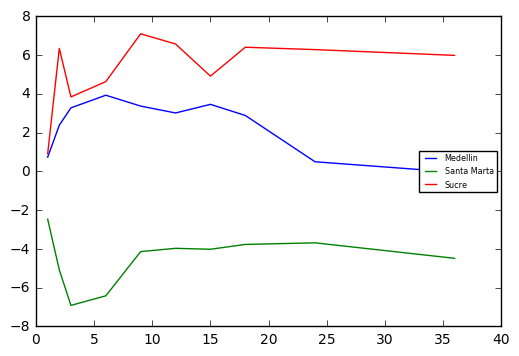

In [26]:
plt.plot(durac,lst_er_Med['Sesgo Ajustada'],label='Medellin')
plt.plot(durac,lst_er_San['Sesgo Ajustada'],label='Santa Marta')
plt.plot(durac,lst_er_Suc['Sesgo Ajustada'],label='Sucre')
plt.legend(fontsize='xx-small',loc=7)
plt.show()

El sesgo es un error mucho más volatil a pequeños periodos de prueba. No obstante al igual que el error RMS este se estabiliza en más de 2 años. 

A continuación se explora el efecto que tiene tomar diferentes años en el error

In [27]:
#Solo se puede fechas entre 2008-2015
mes=1
durac=12

ciudades=["Medellin","SantaMarta","Cali"]
agnos=[2008,2009,2010,2011,2012,2013,2014,2015]

erMed=[None]*len(agnos)
erSan=[None]*len(agnos)
erSuc=[None]*len(agnos)
for idx,agno in enumerate(agnos):
    erMed[idx]=tres_errores(ciudades[0],agno,mes,durac)
    erSan[idx]=tres_errores(ciudades[1],agno,mes,durac)
    erSuc[idx]=tres_errores(ciudades[2],agno,mes,durac)


lst_er_Med=pd.DataFrame(erMed)
lst_er_San=pd.DataFrame(erSan)
lst_er_Suc=pd.DataFrame(erSuc)

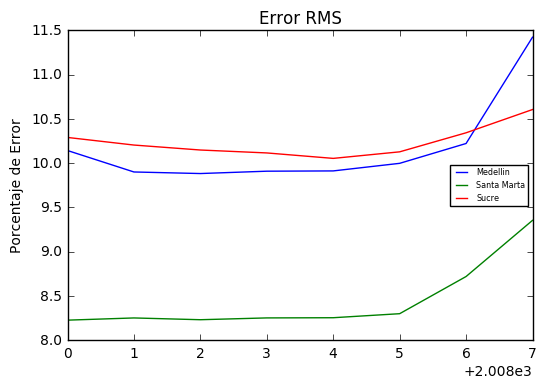

In [57]:
plt.plot(agnos,lst_er_Med['RMS Ajustada'],label='Medellin')
plt.plot(agnos,lst_er_San['RMS Ajustada'],label='Santa Marta')
plt.plot(agnos,lst_er_Suc['RMS Ajustada'],label='Sucre')
plt.legend(fontsize='xx-small',loc=7)
plt.ylabel('Porcentaje de Error')
plt.title('Error RMS')
plt.show()

Esta grafica muestra que en la mayoria de los casos el año en el que se toma la muestra no importa pues esto no genera una gran varianza en el error. Los unicos puntos que se destacan son los ultimos donde se observa que en las tres series el error  sube drasticamente. Esto puede ser por el fenomeo del Niño que ocurrio en el 2015.

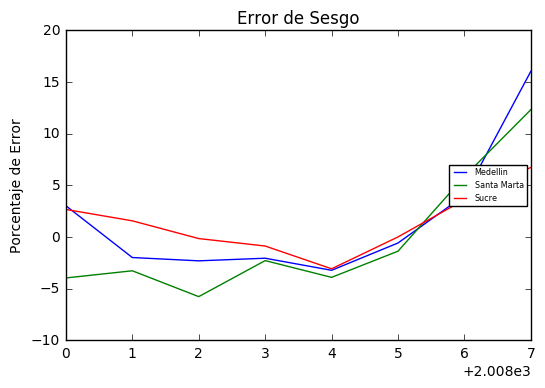

In [59]:
plt.plot(agnos,lst_er_Med['Sesgo Ajustada'],label='Medellin')
plt.plot(agnos,lst_er_San['Sesgo Ajustada'],label='Santa Marta')
plt.plot(agnos,lst_er_Suc['Sesgo Ajustada'],label='Sucre')
plt.legend(fontsize='xx-small',loc=7)
plt.ylabel('Porcentaje de Error')
plt.title('Error de Sesgo')
plt.show()

Así como en la grafica anterior el error se mantiene en un rango aceptable en los primeros 5 años. No obstante entre más cerca al 2015 se esta más crece el error de sesgo.

En la siguiente sección se graficaran las series de GHI diario mensual por el periodo total para las funcion ajustada con las mismas 3 ciudades anteriormente usadas. Esto se hace con el fin de intentar identificar los patrones que existen.

In [60]:

ciudades=["Cali","Medellin","SantaMarta","Sucre","Valledupar","Carmendebolivar"]


def graficarMensual(city):
    base_dir=os.path.join('.','data')
    #Solo se puede fechas entre 2006-2015
    mes=1
    agno=2014
    dura=12
    #  Fuentes
    fObj='IDEAM'
    fRef='NREL'
    
    serie_ob=cargarserie(base_dir,city,fObj)
    serie_ref=cargarserie(base_dir,city,fRef)

    serie_obC=serie_corta(serie_ob,agno,mes,dura)
    m=prediccion_VR(serie_obC,serie_ref)
    serie_aju=serie_ref.copy()
    serie_aju.loc[:,list(serie_ref)[-1]]=m
    serie_aju=serie_aju.reset_index(drop=True)
    serie_mens=ghi_por_mes(serie_ob)
    print(serie_mens.loc[serie_mens["GHIdiario"]==(serie_mens["GHIdiario"].min())]['AÑO'])
    plt.plot(range(len(serie_mens['GHIdiario'])),serie_mens['GHIdiario'])
    plt.title(city)
    plt.ylabel('GHI diario [kWh]')
    plt.show()
   

73    2013.0
Name: AÑO, dtype: float64


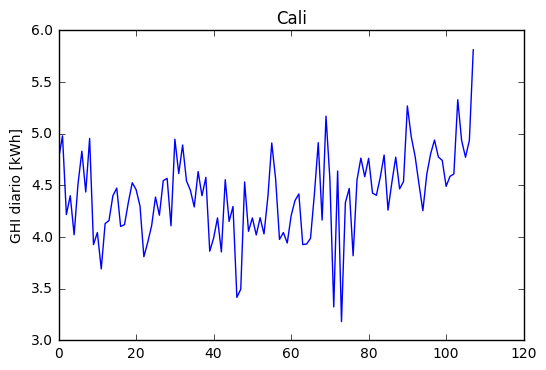

In [39]:
graficarMensual(ciudades[0])

34    2008.0
Name: AÑO, dtype: float64


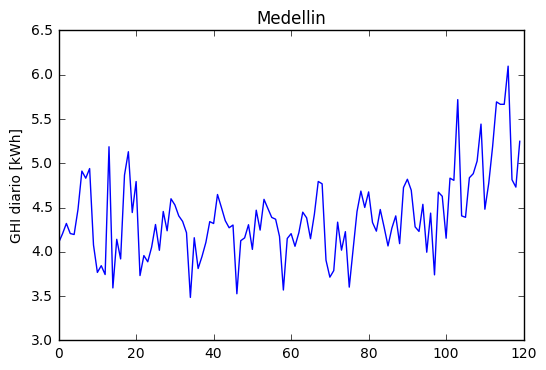

In [40]:
graficarMensual(ciudades[1])

35    2010.0
Name: AÑO, dtype: float64


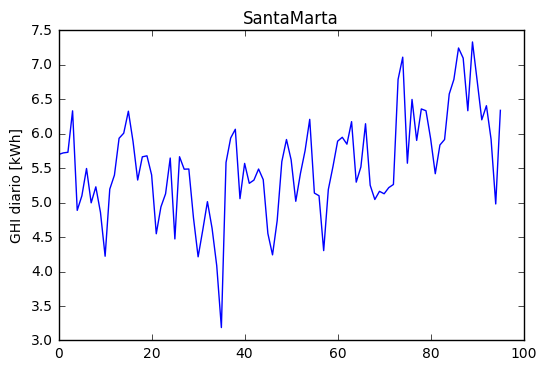

In [41]:
graficarMensual(ciudades[2])

70    2011.0
Name: AÑO, dtype: float64


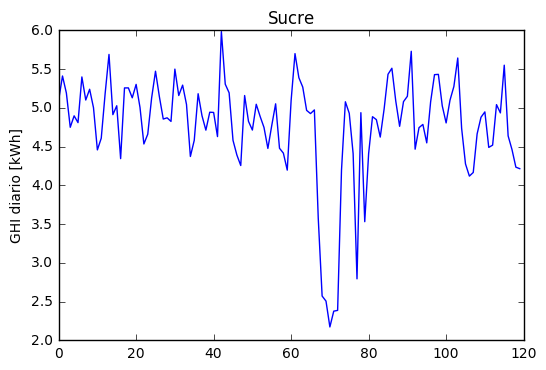

In [42]:
graficarMensual(ciudades[3])

De las anteriores 4 graficas se observa inicialmete que existen ciertos patrones que ser repiten cada 12 meses. Esto se nota especialente en los primeros 60 meses de valledupar, los meses 20-40 en Medellin, 36-80 en Santa Marta y 24 a 60 en Cali. A pesar de esto es importante a clarar que tambien existen periodos de tiempos donde el clima sale de estos patrones como el mes 70 en Sucre, o el mes 37 de Santa Marta. Estos son picos o valles que descuadran completamente el patron que se ve. Algo más que se nota de las graficas son los ultimos años en Santa Marta, Medellin y Cali. En estas ciudades la cantidad de energía aumenta, esto puede concordar o con los años del niño o simplemente con el cambio climatico. 


El siguiente analisis que se hara es uno estudio donde se comparará las las mediciones en periodos más cortos para realmente observar las diferencias entre las serie de referencia, la ajustada y la objetiva. Esto se hara unicamente con la ciudad de Medellin, donde se observaran las diferencias entre las 3 series por 3 dias

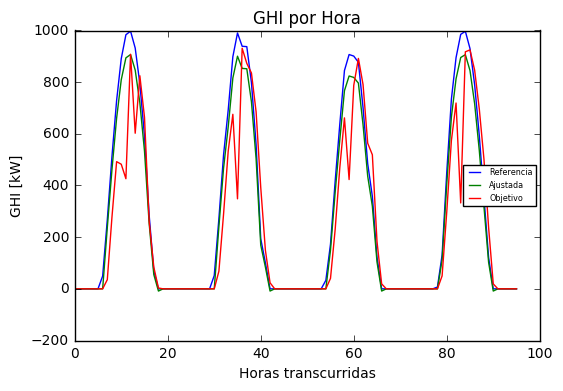

In [84]:
#Solo se puede fechas entre 2006-2015
mes=1
agno=2014
dura=12
#  Fuentes
fObj='IDEAM'
fRef='NREL'
ciudad='Medellin'
serie_ob=cargarserie(base_dir,city,fObj)
serie_ref=cargarserie(base_dir,city,fRef)
serie_obC=serie_corta(serie_ob,agno,mes,dura)
m=prediccion_VR(serie_obC,serie_ref)

serie_aju=serie_ref.copy()
serie_aju.loc[:,list(serie_ref)[-1]]=m
serie_aju=serie_aju.reset_index(drop=True)
   
dias_aju=serie_aju.loc[(serie_aju["AÑO"]==2011) & (serie_aju["MES"]==4) & (serie_aju["DIA"]<=4)]
dias_ob=serie_ob.loc[(serie_ob["AÑO"]==2011) & (serie_ob["MES"]==4) & (serie_ob["DIA"]<=4)]
dias_ref=serie_ref.loc[(serie_ref["AÑO"]==2011) & (serie_ref["MES"]==4) & (serie_ref["DIA"]<=4)]

plt.plot(range(len(dias_ref["GHI"])),dias_ref["GHI"],label='Referencia')
plt.plot(range(len(dias_aju["GHI"])),dias_aju["GHI"],label='Ajustada')
plt.plot(range(len(dias_ob["GHI"])),dias_ob["GHI"],label='Objetivo')
plt.legend(loc=7,fontsize='xx-small')
plt.title('GHI por Hora')
plt.xlabel('Horas transcurridas')
plt.ylabel('GHI [kW]')
plt.show()

La anterior grafica probablemente es una grafica que es de las que más nos diga sobre el comportamiento de la predicción del GHI usando el NREL. Aqui se muestra como el IDEAM reporta varios picos y caidas cada dia mientras que el NREL y la serio ajustada unicamente muestran un pico continuo o montañas. Esta diferencia es la que explica los errores anteriormente encontrado. El error RMS aumenta porque cuando el IDEAM disminuye la predicción sigue aumentando. Por otro lado este afecta el error de sesgo porque la mayoria de las veces el valor predicho es mayor al del IDEAM. 

Estas discrepancia pueden provenir condiciones especificas y diminutas que el NREL no alcanza a identificar, por ejemplo la cobertura de las nubes. Esto lleva a concluir que para poder llegar a obtener una predicción más exacta sobre el procedimiento es necesario algun tipo de sensor que complemente elNREL para detectar estos valles y ajustar el modelo para mejorara la prediccion

Finalmente a continuación se compararan los Enficcs.

In [87]:
ciudades=['Barranquilla','Cali','Carmendebolivar','Medellin',
         'SantaMarta','Sucre','Uribia','Valledupar']

mes=1
agno=2011
dura=12
#  Fuentes
fObj='IDEAM'
fRef='NREL'

lst_ciudades=[None]*len(ciudades)
for idx,city in enumerate(ciudades):
        #Cargar cada serie segun la fuente
    serie_ob=cargarserie(base_dir,city,fObj)
    serie_ref=cargarserie(base_dir,city,fRef)



    serie_obC=serie_corta(serie_ob,agno,mes,dura)
    m=prediccion_VR(serie_obC,serie_ref)

    serie_pred=serie_ref.copy()   
    serie_pred.loc[:,list(serie_ref)[-1]]=m
    enficc_ob=ENFICC(serie_ob)
    enficc_ref=ENFICC(serie_ref)
    enficc_pred=ENFICC(serie_pred)
    dic_city={"Ciudad":city,'Objetivo':enficc_ob,'Referencia':enficc_ref,'Ajustada':enficc_pred}
    lst_ciudades[idx]=dic_city

df_enficc=pd.DataFrame(lst_ciudades)


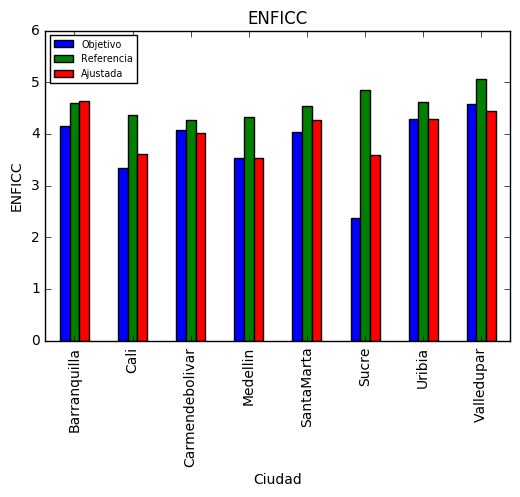

In [91]:
plt_enficc=df_enficc.plot(x='Ciudad',y=["Objetivo","Referencia","Ajustada"],kind='bar')
plt_enficc.legend(loc=2,fontsize='x-small')
plt_enficc.set_ylabel('ENFICC')
plt_enficc.set_title('ENFICC')

Esta ultima grafica muestra la efectividad de los metodos para calcular el ENFICC. Lo primero que se observa es que el NREL siempre sobreestima el ENFICC la mayor diferencia se ve en Sucre la cual es de aproximadamente de 2. Ahora bien la serie ajustada logra imitar la serie objetiva mucho más. En todas excepto Valledupar esta sobreestima la radiocion del sol. Esto concuerda con lo encontrado en la grafica anterior en la cual se observo que la serie ajustada en promedio tiene valores mayores que la serie objetiva. 